# Clasificarea Website-urilor folosind algoritmi de învățare automată

Echipa: Domșa Daiana și Alexandru Nechita

Set de date: https://archive.ics.uci.edu/dataset/327/phishing+websites

## Incarcare dataset si preprocesare

Setul de date a fost furnizat în format .arff, deci a fost citit folosind *scipy.io.arff.loadarff*.

A fost convertit într-un DataFrame Pandas pentru o procesare ușoară.

A fost analizată distribuția claselor și valoarea lipsă.

Explorarea inițială este esențială pentru a înțelege structura datelor, echilibrul claselor și prezența valorilor lipsă sau anormale.

**Preprocesare**

Eticheta (clasa) a fost convertită din b'1', b'-1' în valori numerice -1 și 1.

Au fost verificate valorile lipsă și convertite toate coloanele în format numeric.

A fost aplicată standardizarea (folosind StandardScaler) pentru a aduce toate valorile pe aceeași scară

Standardizarea este importantă pentru modele precum Logistic Regression, SVM sau MLP care sunt sensibile la magnitudinea caracteristicilor.

Conversia etichetelor binare este necesară pentru compatibilitate cu scikit-learn.

In [ ]:
from scipy.io import arff
import pandas as pd

# Incarcarea setului de date
data, meta = arff.loadarff('trainingDataset.arff')

# Transformare in DataFrame
df = pd.DataFrame(data)

# Decodificarea valorilor
def decode_val(x):
    if isinstance(x, bytes):
        return int(x.decode('utf-8'))
    return int(x)

df = df.map(decode_val)

df.head()


having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0                 -1           1                   1                 1   
1                  1           1                   1                 1   
2                  1           0                   1                 1   
3                  1           0                   1                 1   
4                  1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   Domain_registeration_length  Favicon  ...  popUpWidnow  Iframe  \
0                           -1        1  ...            1       1   
1                           -1        1  ...            1       1   
2                           -1        1  ...            1       1   
3                            1        1  ...            1       1   
4                           -1        1  ...           -1       1   

   age_of_domain  DNSRecord  web_traffic  Page_Rank  Google_Index  \
0             -1         -1           -1         -1             1   
1             -1         -1            0         -1             1   
2              1         -1            1         -1             1   
3             -1         -1            1         -1             1   
4             -1         -1            0         -1             1   

   Links_pointing_to_page  Statistical_report  Result  
0                       1                  -1      -1  
1                       1                   1      -1  
2                       0                  -1      -1  
3                      -1                   1      -1  
4                       1                   1       1  

[5 rows x 31 columns]

In [ ]:
df.isnull().sum().sum() # Rezultatul este 0

# Distributia clasei
df['Result'].value_counts(normalize=True)


Result
 1    0.556943
-1    0.443057
Name: proportion, dtype: float64

In [ ]:
# Statistici pentru cateva atribute
selected = ['URL_Length', 'having_At_Symbol', 'on_mouseover']
desc = df[selected].describe().T
desc['mode'] = [df[col].mode()[0] for col in selected]
desc = desc[['mode', 'mean', '50%', 'std']]
desc.columns = ['Modă', 'Medie', 'Mediană', 'STD']
print("\nStatistici descriptive:\n", desc)



Statistici descriptive:
                   Modă   Medie  Mediană    STD 
URL_Length         -1  -0.6332   -1.0    0.7661
having_At_Symbol    1   0.7006    1.0    0.7136
on_mouseover        1   0.7621    1.0    0.6475


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df.iloc[:, :-1].hist(figsize=(20, 15), bins=3, edgecolor='black')
plt.suptitle("Distributia valorilor pentru toate cele 30 de atrubite", fontsize=16)
plt.show()


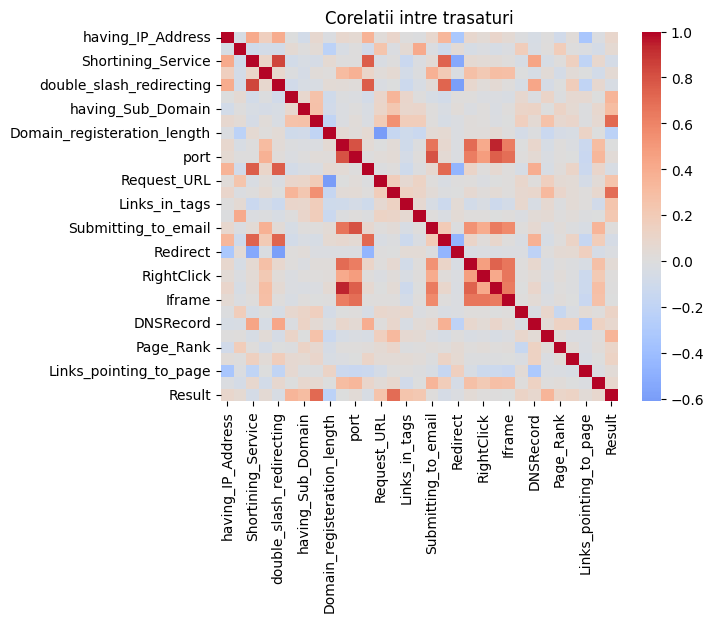

In [ ]:
sns.heatmap(df.corr(), cmap='coolwarm', center=0)
plt.title("Corelatii intre trasaturi")
plt.show()

In [ ]:
# Separarea setului în X (features) si y (eticheta)
X = df.drop("Result", axis=1)
y = df["Result"]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#  Impartirea in set de antrenare si testare
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

model_results = []

# Standardizare
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Functii pentru vizualizare

Vizualizările sprijină interpretarea rezultatelor și identificarea celor mai performante modele

### Curba ROC

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc_val = auc(fpr, tpr)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curba ROC")
    plt.legend(loc="lower right")
    plt.show()


### Curba Precision-Recall

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(model, X_test, y_test):
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='purple', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curba Precision-Recall')
    plt.show()


### Matricea de confuzie

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicții')
    plt.ylabel('Valori adevărate')
    plt.title('Matricea de Confuzie')
    plt.show()


### Bar chart timpi de antrenare

In [ ]:
def plot_training_times(model_names, training_times):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=model_names, y=training_times, palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Timp de antrenare (secunde)')
    plt.title('Compararea timpii de antrenare între modele')
    plt.show()


## Modele care necesita standardizare

- Logistic Regression
- K-Nearest Neighbors
- Support Vector Classifier
- MLPClassifier

Modelele selectate acoperă atât metode clasice (Logistic Regression, Naive Bayes), cât și algoritmi ensemble (Random Forest, Gradient Boosting) și modele complexe (MLP, SVC).

Tuningul parametrilor permite obținerea unei versiuni optimizate pentru fiecare model.

### 1. Logistic Regression

De ce am ales acest model:
- Model de bază pentru clasificare binară. Ușor de interpretat și eficient.

 Parametri tunati:

- C = 0.1 : Regularizare mai puternică; prevenire overfiting
- penalty = l1 : regularizare Lasso
- solver = liblinear : compatibil cu l1 (penalty)

Tuningul nu a îmbunătățit semnificativ performanța, dar a redus timpul de antrenare.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
import time

a. Parametri impliciti

In [ ]:
start = time.time()
model_lr_default = LogisticRegression()
model_lr_default.fit(X_train_scaled, y_train)
end = time.time()

training_time = end - start

y_pred = model_lr_default.predict(X_test_scaled)
print("=== Logistic Regression (default) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, model_lr_default.predict_proba(X_test_scaled)[:, 1]))
print("CV F1-score:", cross_val_score(model_lr_default, X_train_scaled, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model_lr_default.predict_proba(X_test_scaled)[:, 1])
cv_f1 = cross_val_score(model_lr_default, X_train_scaled, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": "Logistic Regression (default)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== Logistic Regression (default) ===
Training time: 0.1784 seconds
[[ 883   97]
 [  61 1170]]
              precision    recall  f1-score   support

          -1       0.94      0.90      0.92       980
           1       0.92      0.95      0.94      1231

    accuracy                           0.93      2211
   macro avg       0.93      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211

ROC AUC: 0.9808024834629221
CV F1-score: 0.9350108511201418


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


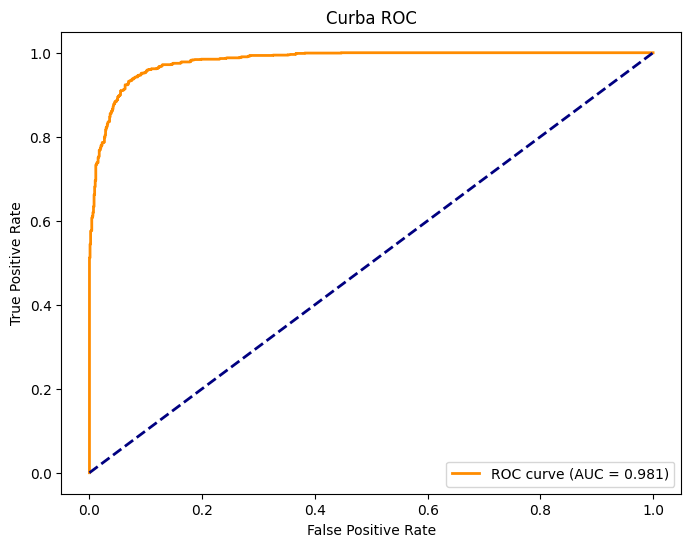

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


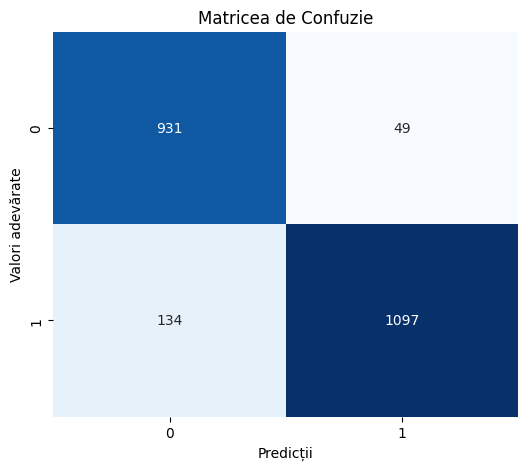

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


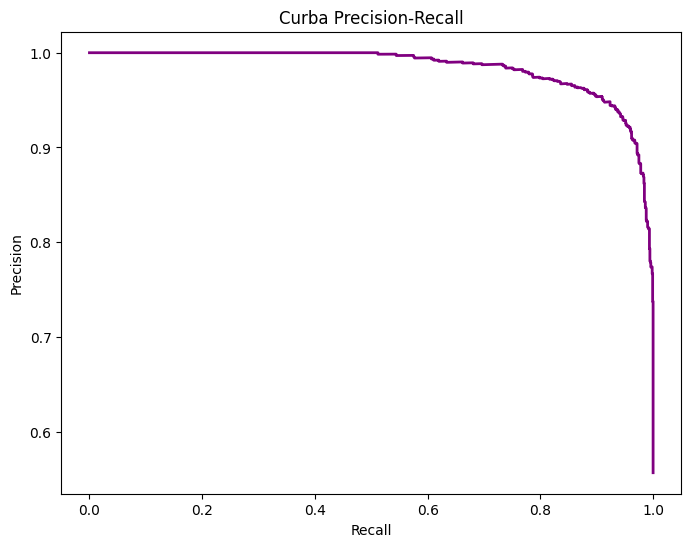

In [ ]:
plot_roc_curve(model_lr_default, X_test, y_test)
plot_confusion_matrix(model_lr_default, X_test, y_test)
plot_precision_recall_curve(model_lr_default, X_test, y_test)

b. Parametri alesi

In [ ]:
start = time.time()
model_lr_tuned = LogisticRegression(
    C=0.1,
    solver='liblinear',
    penalty='l1',
    max_iter=200
)
model_lr_tuned.fit(X_train_scaled, y_train)
end = time.time()

training_time = end - start

# 2. Predictii + evaluare
y_pred_tuned = model_lr_tuned.predict(X_test_scaled)
print("=== Logistic Regression (tuned) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, model_lr_tuned.predict_proba(X_test_scaled)[:, 1]))
print("CV F1-score:", cross_val_score(model_lr_tuned, X_train_scaled, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model_lr_tuned.predict_proba(X_test_scaled)[:, 1])
cv_f1 = cross_val_score(model_lr_tuned, X_train_scaled, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": "Logistic Regression (tuned)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })



=== Logistic Regression (tuned) ===
Training time: 0.0660 seconds
[[ 884   96]
 [  58 1173]]
              precision    recall  f1-score   support

          -1       0.94      0.90      0.92       980
           1       0.92      0.95      0.94      1231

    accuracy                           0.93      2211
   macro avg       0.93      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211

ROC AUC: 0.9804431439513254
CV F1-score: 0.9358779345913699


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


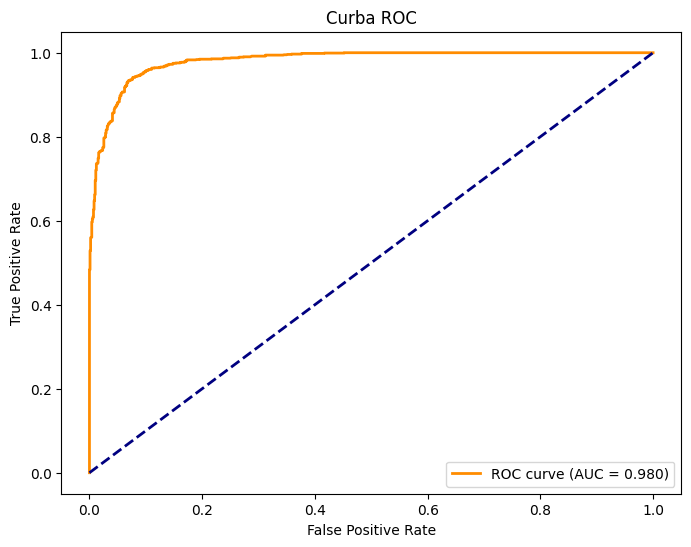

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


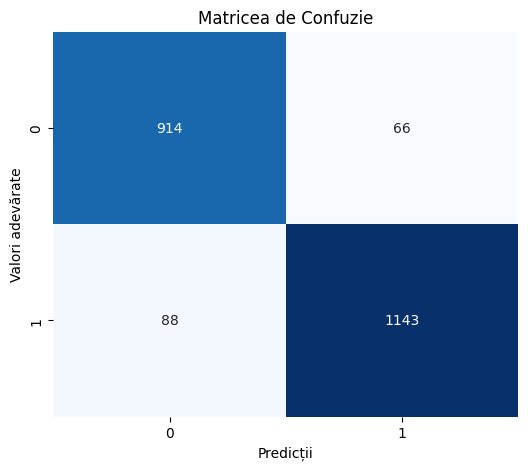

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


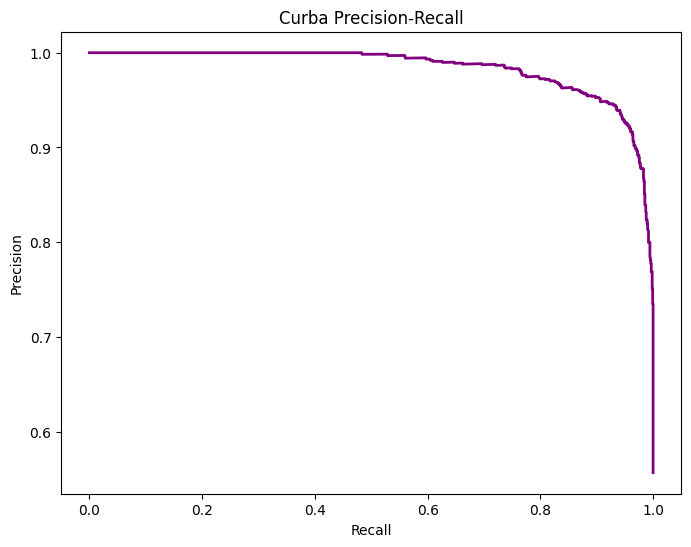

In [ ]:
plot_roc_curve(model_lr_tuned, X_test, y_test)
plot_confusion_matrix(model_lr_tuned, X_test, y_test)
plot_precision_recall_curve(model_lr_tuned, X_test, y_test)

### 2. K-Nearest Neighbors

De ce am ales acest model:

- Metodă intuitivă și simplă. Eficientă după scalarea caracteristicilor.

Parametri tunati:

- n_neighbors = 5: valoare uzuală echilibrată între bias și varianță

- weights = distance: vecinii apropiați au o influență mai mare

- metric = manhattan:


Timpul de antrenare a fost aproape instantaneu, iar scorul F1 a fost competitiv.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
import time

a. Parametri impliciti

In [ ]:
start = time.time()
knn_default = KNeighborsClassifier()
knn_default.fit(X_train_scaled, y_train)

end = time.time()
training_time = end - start


y_pred = knn_default.predict(X_test_scaled)
print("=== KNN (default) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, knn_default.predict_proba(X_test_scaled)[:, 1]))
print("CV F1-score:", cross_val_score(knn_default, X_train_scaled, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, knn_default.predict_proba(X_test_scaled)[:, 1])
cv_f1 = cross_val_score(knn_default, X_train_scaled, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": "KNN (default)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== KNN (default) ===
Training time: 0.0050 seconds
[[ 917   63]
 [  51 1180]]
              precision    recall  f1-score   support

          -1       0.95      0.94      0.94       980
           1       0.95      0.96      0.95      1231

    accuracy                           0.95      2211
   macro avg       0.95      0.95      0.95      2211
weighted avg       0.95      0.95      0.95      2211

ROC AUC: 0.9868677365340938
CV F1-score: 0.9467511185028374


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


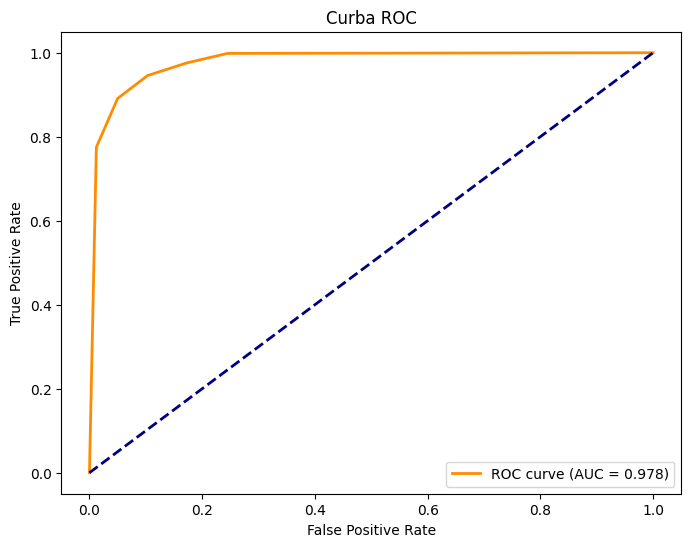

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


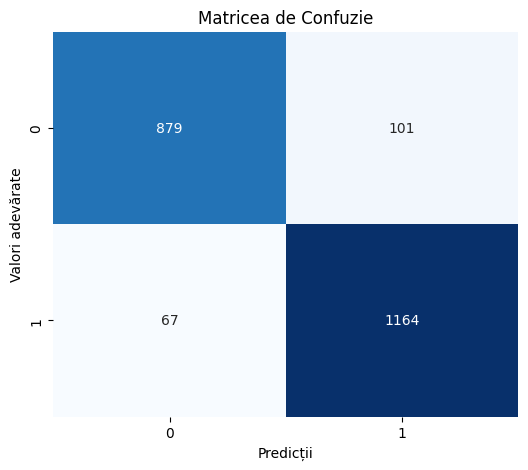

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [ ]:
plot_roc_curve(knn_default, X_test, y_test)
plot_confusion_matrix(knn_default, X_test, y_test)
plot_precision_recall_curve(knn_default, X_test, y_test)

b. Parametri alesi

In [ ]:
start = time.time()

knn_tuned = KNeighborsClassifier(
    n_neighbors=7,
    weights='distance',
    metric='manhattan'
)
knn_tuned.fit(X_train_scaled, y_train)

end = time.time()
training_time = end - start

y_pred_tuned = knn_tuned.predict(X_test_scaled)
print("=== KNN (tuned) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, knn_tuned.predict_proba(X_test_scaled)[:, 1]))
print("CV F1-score:", cross_val_score(knn_tuned, X_train_scaled, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, knn_tuned.predict_proba(X_test_scaled)[:, 1])
cv_f1 = cross_val_score(knn_tuned, X_train_scaled, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": "KNN (tuned)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== KNN (tuned) ===
Training time: 0.0057 seconds
[[ 937   43]
 [  25 1206]]
              precision    recall  f1-score   support

          -1       0.97      0.96      0.96       980
           1       0.97      0.98      0.97      1231

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211

ROC AUC: 0.9922482965566406
CV F1-score: 0.9663721357648984


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


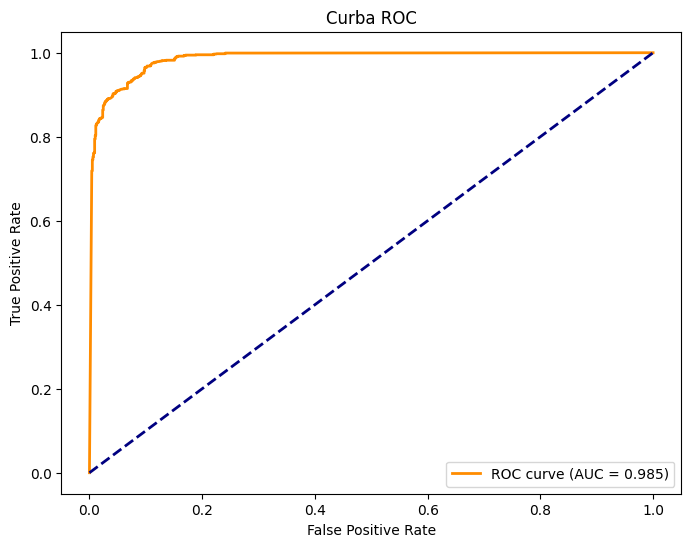

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


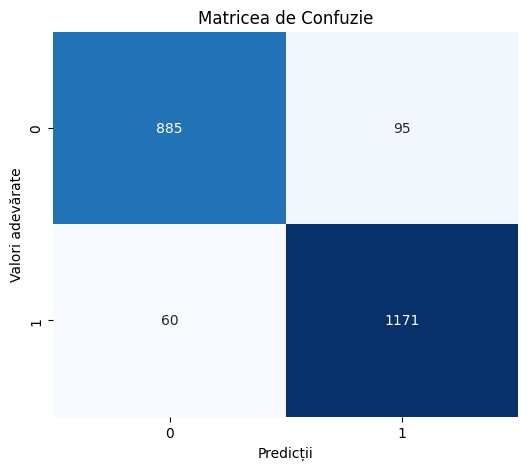

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


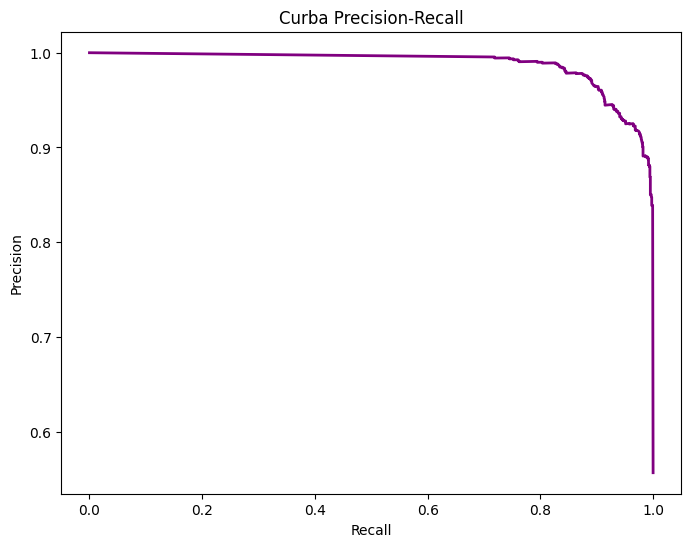

In [ ]:
plot_roc_curve(knn_tuned, X_test, y_test)
plot_confusion_matrix(knn_tuned, X_test, y_test)
plot_precision_recall_curve(knn_tuned, X_test, y_test)

### 3. Support Vector Classifier

De ce am ales acest model:

- Puternic pentru clasificări binare, mai ales când datele sunt bine separate în spațiu.

Parametri tunati:

- C = 10: margine mai strictă, penalizare mai mare pentru clasificări greșite

- gamma = scale: scalare automată în funcție de numărul de caracteristici

- kernel = rbf: captează relații nelineare

A crescut scorul F1 dar cu un timp de antrenare semnificativ mai mare.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
import time

a. Parametri impliciti

In [ ]:
start = time.time()

svc_default = SVC(probability=True)  # probability=True pentru roc_auc_score
svc_default.fit(X_train_scaled, y_train)

end = time.time()
training_time = end - start

# Predictii + evaluare
y_pred = svc_default.predict(X_test_scaled)
print("=== SVC (default, RBF kernel) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, svc_default.predict_proba(X_test_scaled)[:, 1]))
print("CV F1-score:", cross_val_score(svc_default, X_train_scaled, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, svc_default.predict_proba(X_test_scaled)[:, 1])
cv_f1 = cross_val_score(svc_default, X_train_scaled, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": "SVC (default)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== SVC (default, RBF kernel) ===
Training time: 8.3152 seconds
[[ 906   74]
 [  33 1198]]
              precision    recall  f1-score   support

          -1       0.96      0.92      0.94       980
           1       0.94      0.97      0.96      1231

    accuracy                           0.95      2211
   macro avg       0.95      0.95      0.95      2211
weighted avg       0.95      0.95      0.95      2211

ROC AUC: 0.9893267461330592
CV F1-score: 0.9537024674778056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


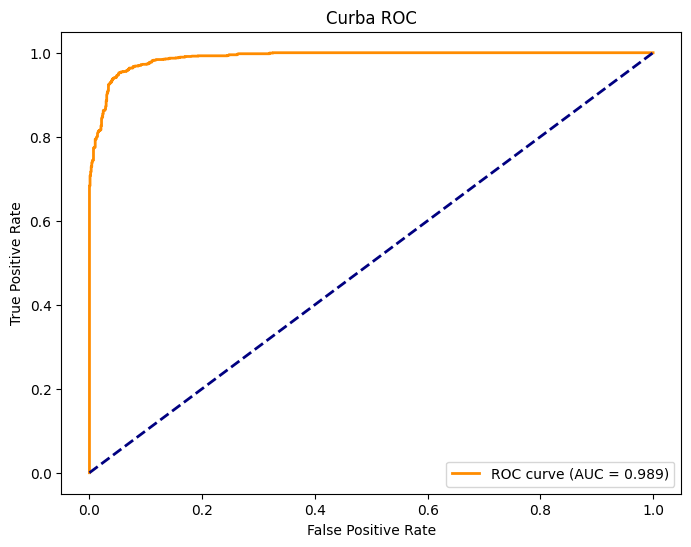

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


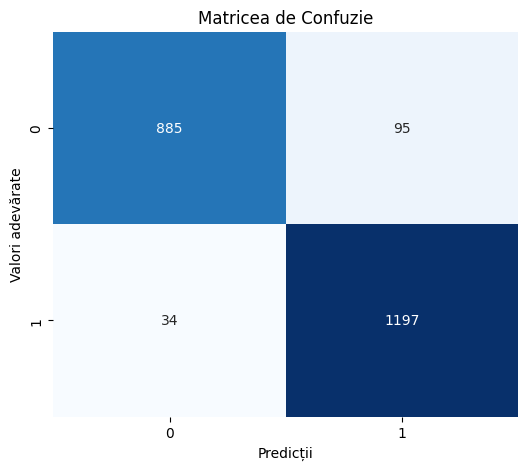

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


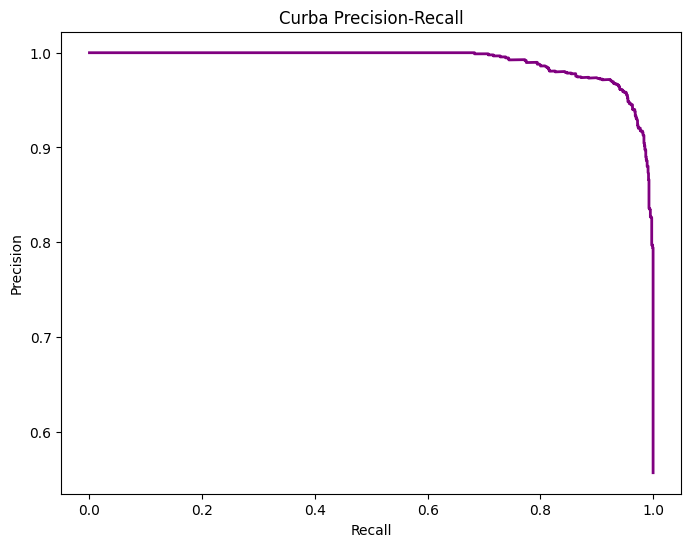

In [ ]:
plot_roc_curve(svc_default, X_test, y_test)
plot_confusion_matrix(svc_default, X_test, y_test)
plot_precision_recall_curve(svc_default, X_test, y_test)

b. Parametri alesi

In [ ]:
start = time.time()
svc_rbf_tuned = SVC(kernel='rbf', C=10, gamma=0.01, probability=True)
svc_rbf_tuned.fit(X_train_scaled, y_train)

end = time.time()
training_time = end - start

y_pred_rbf = svc_rbf_tuned.predict(X_test_scaled)
print("=== SVC (RBF kernel tuned) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred_rbf))
print(classification_report(y_test, y_pred_rbf))
print("ROC AUC:", roc_auc_score(y_test, svc_rbf_tuned.predict_proba(X_test_scaled)[:, 1]))
print("CV F1-score:", cross_val_score(svc_rbf_tuned, X_train_scaled, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, svc_rbf_tuned.predict_proba(X_test_scaled)[:, 1])
cv_f1 = cross_val_score(svc_rbf_tuned, X_train_scaled, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": "SVC (tuned)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== SVC (RBF kernel tuned) ===
Training time: 7.8078 seconds
[[ 909   71]
 [  29 1202]]
              precision    recall  f1-score   support

          -1       0.97      0.93      0.95       980
           1       0.94      0.98      0.96      1231

    accuracy                           0.95      2211
   macro avg       0.96      0.95      0.95      2211
weighted avg       0.96      0.95      0.95      2211

ROC AUC: 0.9915449526683136
CV F1-score: 0.9541024591909879


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


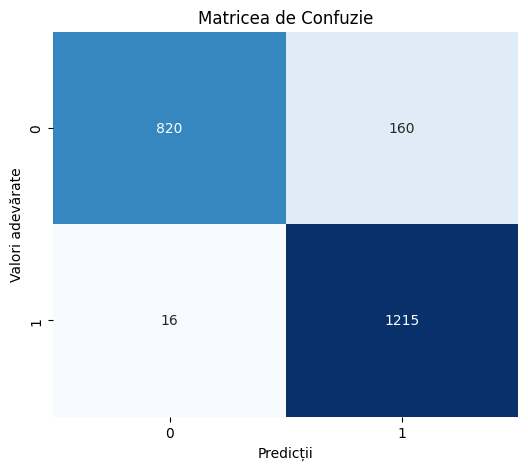

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [ ]:
plot_roc_curve(svc_rbf_tuned, X_test, y_test)
plot_confusion_matrix(svc_rbf_tuned, X_test, y_test)
plot_precision_recall_curve(svc_rbf_tuned, X_test, y_test)

### 4. MLP Classifier

De ce am ales acest model:

- Capabil să învețe relații complexe nelineare. Poate obține rezultate excelente cu un tuning corespunzător.

Parametri tunati:

- hidden_layer_sizes=(50, 30): pentru a oferi modelului capacitate de învățare suficientă, dar fără a-l supracomplexa.

- activation='relu':Funcția ReLU este eficientă în rețele adânci, evitând problema vanishing gradient

- solver='adam': Optimizator adaptiv, foarte potrivit pentru seturi de date mari și pentru rețele cu mai multe straturi

- alpha=0.0001: Valoarea mică previne overfitting fără a restrânge prea mult capacitatea modelului

- learning_rate='adaptive': Rata de învățare se ajustează automat pe parcursul antrenării, în funcție de performanță

- max_iter=500: Număr crescut de epoci pentru a permite convergența completă a modelului

- random_state=42: Asigură reproductibilitate

Tuningul a redus considerabil timpul de antrenare și a menținut scorul F1 ridicat.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
import time

a. Parametri impliciti

In [ ]:
start = time.time()

mlp_default = MLPClassifier(max_iter=300, random_state=42)
mlp_default.fit(X_train_scaled, y_train)

end = time.time()
training_time = end - start

y_pred = mlp_default.predict(X_test_scaled)
print("=== MLPClassifier (default) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, mlp_default.predict_proba(X_test_scaled)[:, 1]))
print("CV F1-score:", cross_val_score(mlp_default, X_train_scaled, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, mlp_default.predict_proba(X_test_scaled)[:, 1])
cv_f1 = cross_val_score(mlp_default, X_train_scaled, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": "MLPClassifier (default)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== MLPClassifier (default) ===
Training time: 18.5543 seconds
[[ 938   42]
 [  17 1214]]
              precision    recall  f1-score   support

          -1       0.98      0.96      0.97       980
           1       0.97      0.99      0.98      1231

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211

ROC AUC: 0.9970365888028648
CV F1-score: 0.9702403503674123


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


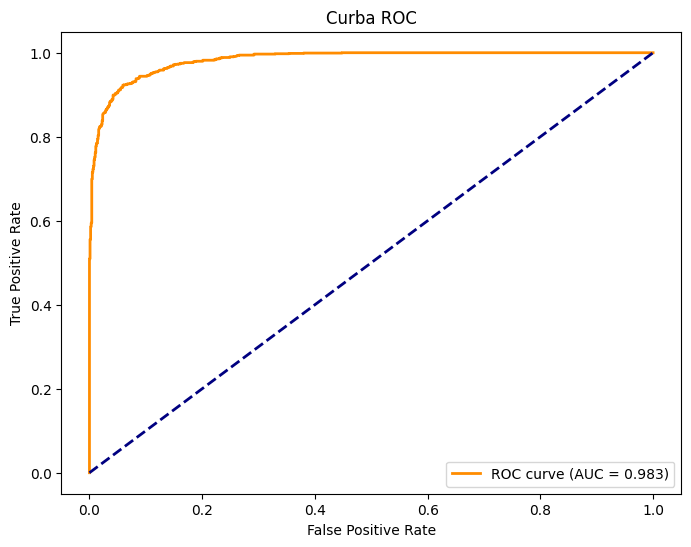

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


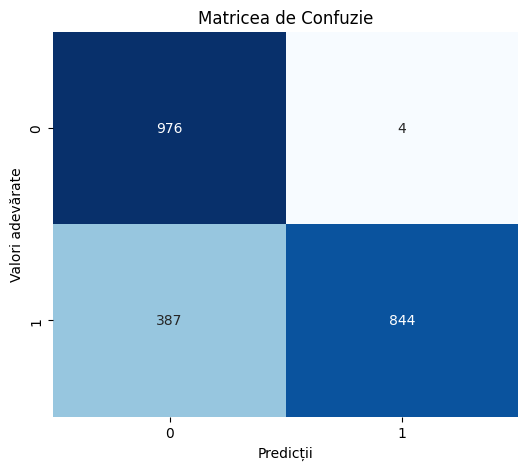

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


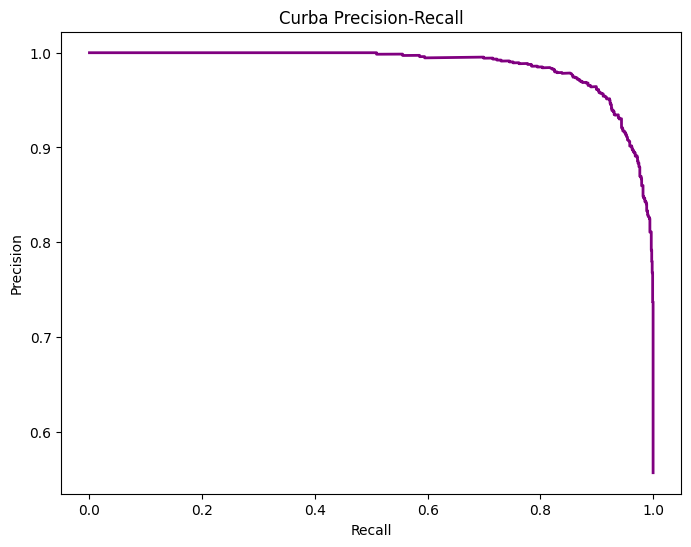

In [ ]:
plot_roc_curve(mlp_default, X_test, y_test)
plot_confusion_matrix(mlp_default, X_test, y_test)
plot_precision_recall_curve(mlp_default, X_test, y_test)

b. Parametri alesi

In [ ]:
start = time.time()
mlp_tuned = MLPClassifier(
    hidden_layer_sizes=(50, 30),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42
)
mlp_tuned.fit(X_train_scaled, y_train)

end = time.time()
training_time = end - start

y_pred_tuned = mlp_tuned.predict(X_test_scaled)
print("=== MLPClassifier (tuned) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, mlp_tuned.predict_proba(X_test_scaled)[:, 1]))
print("CV F1-score:", cross_val_score(mlp_tuned, X_train_scaled, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, mlp_tuned.predict_proba(X_test_scaled)[:, 1])
cv_f1 = cross_val_score(mlp_tuned, X_train_scaled, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": "MLPClassifier (tuned)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== MLPClassifier (tuned) ===
Training time: 7.9516 seconds
[[ 937   43]
 [  20 1211]]
              precision    recall  f1-score   support

          -1       0.98      0.96      0.97       980
           1       0.97      0.98      0.97      1231

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211

ROC AUC: 0.9961102637643197
CV F1-score: 0.9672941071854764


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


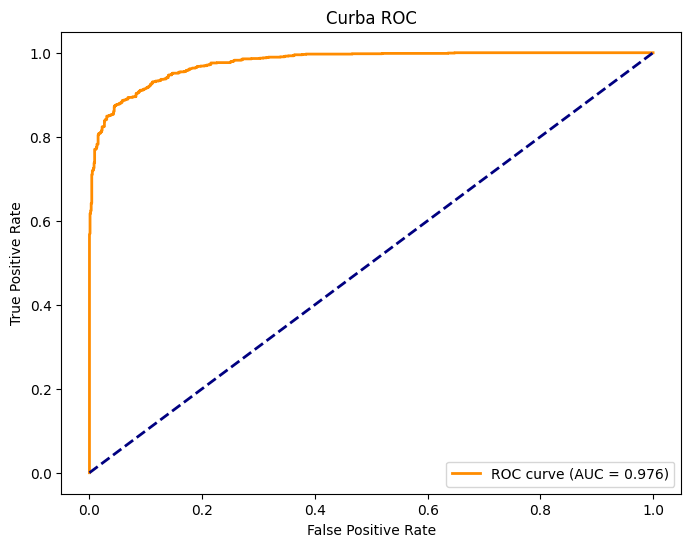

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


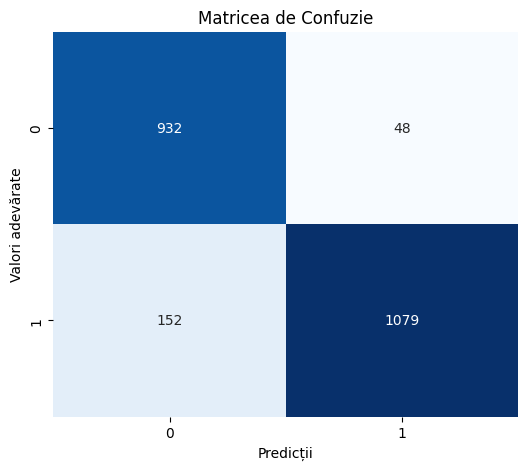

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


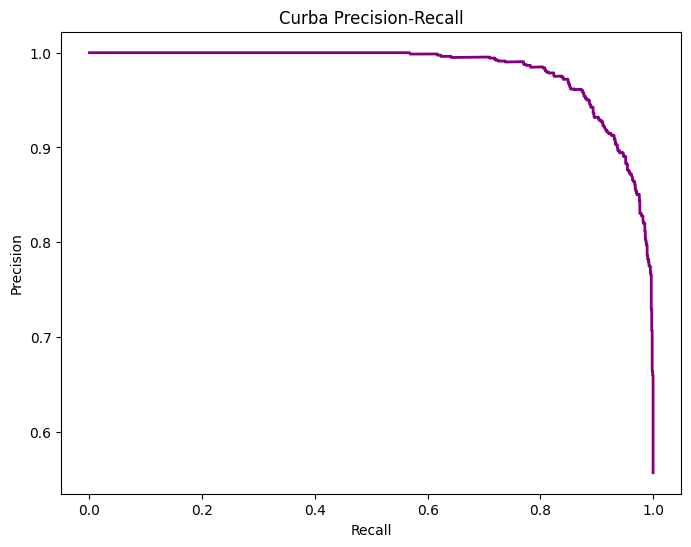

In [ ]:
plot_roc_curve(mlp_tuned, X_test, y_test)
plot_confusion_matrix(mlp_tuned, X_test, y_test)
plot_precision_recall_curve(mlp_tuned, X_test, y_test)

## Modele care nu necesita standardizare

- GaussianNB
- Decision Tree Classifier
- Random Forest Classifier
- Gradient Boosting Classifier

### 5. GaussianNB

De ce am ales acest model:

- Foarte rapid și simplu. Se bazează pe presupunerea de independență între feature-uri.

Parametri tunati:

- var_smoothing = 1e-1: adaugă stabilitate la împărțirea la varianțe foarte mici

A avut o creștere semnificativă la scorul F1 de validare (CV F1), deși pe test a rămas slab.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import time

a. Parametri impliciti

In [ ]:
start = time.time()
gnb_default = GaussianNB()
gnb_default.fit(X_train, y_train)
y_pred = gnb_default.predict(X_test)

end = time.time()
training_time = end - start

print("=== GaussianNB (default) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, gnb_default.predict_proba(X_test)[:,1]))
print("CV F1-score:", cross_val_score(gnb_default, X_train, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, gnb_default.predict_proba(X_test)[:,1])
cv_f1 = cross_val_score(gnb_default, X_train, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": " GaussianNB (default)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })
gnb = GaussianNB()


=== GaussianNB (default) ===
Training time: 0.0104 seconds
[[979   1]
 [882 349]]
              precision    recall  f1-score   support

          -1       0.53      1.00      0.69       980
           1       1.00      0.28      0.44      1231

    accuracy                           0.60      2211
   macro avg       0.76      0.64      0.57      2211
weighted avg       0.79      0.60      0.55      2211

ROC AUC: 0.9702083920489398
CV F1-score: 0.44822977240864426


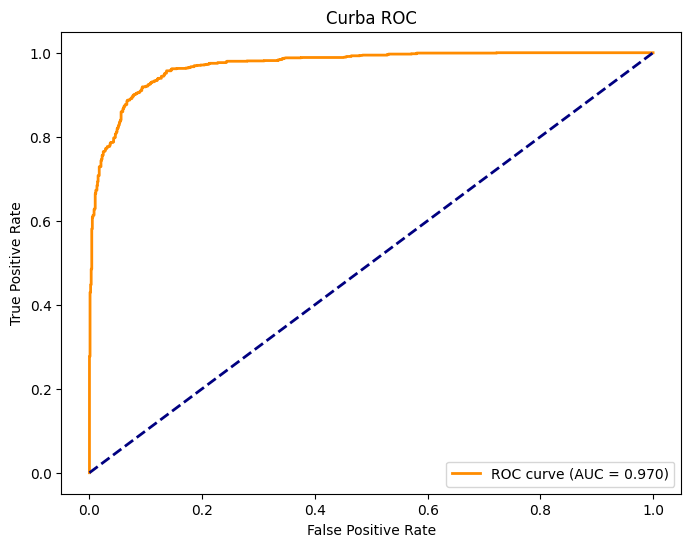

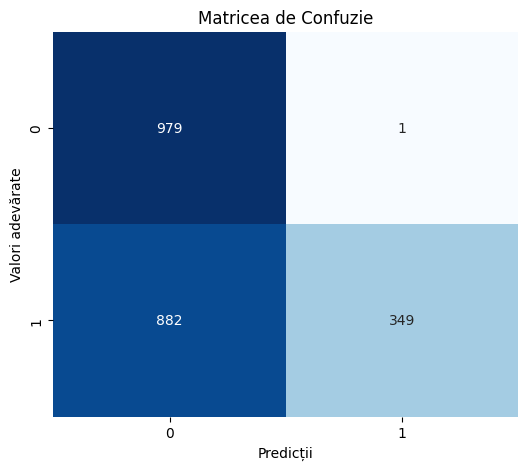

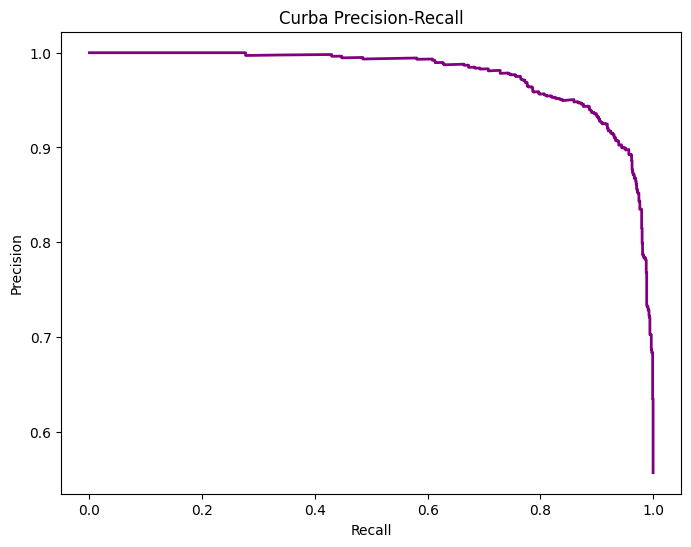

In [ ]:
plot_roc_curve(gnb_default, X_test, y_test)
plot_confusion_matrix(gnb_default, X_test, y_test)
plot_precision_recall_curve(gnb_default, X_test, y_test)

b. Parametri alesi

In [ ]:
# Tunat (var_smoothing modificat)
start = time.time()
gnb_tuned = GaussianNB(var_smoothing=1e-1)
gnb_tuned.fit(X_train, y_train)
y_pred_tuned = gnb_tuned.predict(X_test)

end = time.time()
training_time = end - start
print("=== GaussianNB (tuned) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, gnb_tuned.predict_proba(X_test)[:,1]))
print("CV F1-score:", cross_val_score(gnb_tuned, X_train, y_train, cv=5, scoring='f1').mean())


f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, gnb_tuned.predict_proba(X_test)[:,1])
cv_f1 = cross_val_score(gnb_tuned, X_train, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": " GaussianNB (tuned)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== GaussianNB (tuned) ===
Training time: 0.0110 seconds
[[ 901   79]
 [ 126 1105]]
              precision    recall  f1-score   support

          -1       0.88      0.92      0.90       980
           1       0.93      0.90      0.92      1231

    accuracy                           0.91      2211
   macro avg       0.91      0.91      0.91      2211
weighted avg       0.91      0.91      0.91      2211

ROC AUC: 0.9698660455246275
CV F1-score: 0.9110151767084498


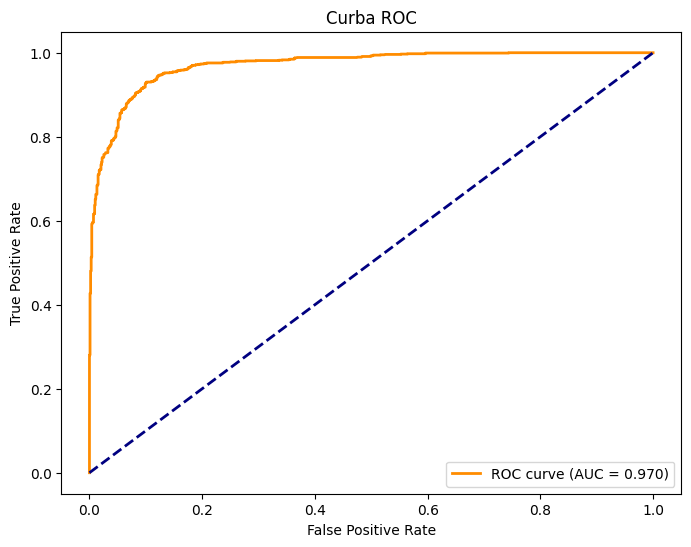

In [ ]:
plot_roc_curve(gnb_tuned, X_test, y_test)
plot_confusion_matrix(gnb_tuned, X_test, y_test)
plot_precision_recall_curve(gnb_tuned, X_test, y_test)

### 6. Decision Tree Classifier

De ce am ales acest model:

- Ușor de interpretat, foarte rapid de antrenat, bun ca referință de bază.
Parametri tunati:

- criterion='gini': mai rapidă și frecvent utilizată în practică

- max_depth=10: limitarea adâncimii previne overfittingul

- min_samples_split=5: Reduce fragmentarea excesivă a datelor și controlează creșterea arborelui

- min_samples_leaf=2: Ajută la prevenirea frunzelor izolate, care pot fi cauzate de zgomot în date

- random_state=42: Asigură reproducibilitate


Performanța s-a îmbunătățit puțin pe validare, dar F1 score-ul a rămas constant.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import time

a. Parametri impliciti

In [ ]:
start = time.time()
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)
y_pred = dt_default.predict(X_test)

end = time.time()
training_time = end - start

print("=== Decision Tree (default) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, dt_default.predict_proba(X_test)[:,1]))
print("CV F1-score:", cross_val_score(dt_default, X_train, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, dt_default.predict_proba(X_test)[:,1])
cv_f1 = cross_val_score(dt_default, X_train, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": " Decision Tree (default)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== Decision Tree (default) ===
Training time: 0.0264 seconds
[[ 943   37]
 [  27 1204]]
              precision    recall  f1-score   support

          -1       0.97      0.96      0.97       980
           1       0.97      0.98      0.97      1231

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211

ROC AUC: 0.9804522621396243
CV F1-score: 0.9644636386037956


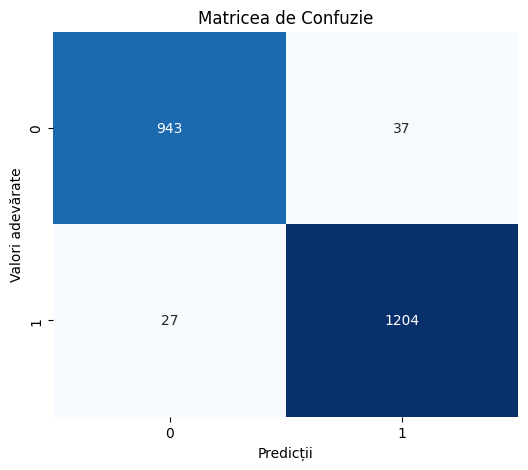

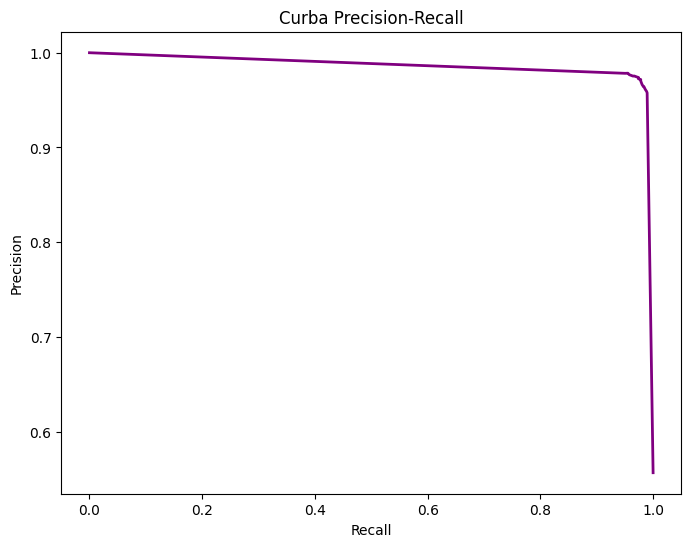

In [ ]:
plot_roc_curve(dt_default, X_test, y_test)
plot_confusion_matrix(dt_default, X_test, y_test)
plot_precision_recall_curve(dt_default, X_test, y_test)

b. Parametri alesi

In [ ]:
start = time.time()
dt_tuned = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
dt_tuned.fit(X_train, y_train)
y_pred_tuned = dt_tuned.predict(X_test)

end = time.time()
training_time = end - start

print("=== Decision Tree (tuned) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, dt_tuned.predict_proba(X_test)[:,1]))
print("CV F1-score:", cross_val_score(dt_tuned, X_train, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, dt_tuned.predict_proba(X_test)[:,1])
cv_f1 = cross_val_score(dt_tuned, X_train, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": " Decision Tree (tuned)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== Decision Tree (tuned) ===
Training time: 0.0359 seconds
[[ 926   54]
 [  64 1167]]
              precision    recall  f1-score   support

          -1       0.94      0.94      0.94       980
           1       0.96      0.95      0.95      1231

    accuracy                           0.95      2211
   macro avg       0.95      0.95      0.95      2211
weighted avg       0.95      0.95      0.95      2211

ROC AUC: 0.9864847726255409
CV F1-score: 0.9490778460370572


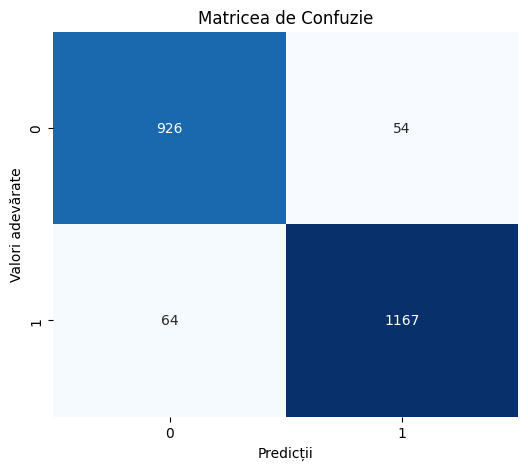

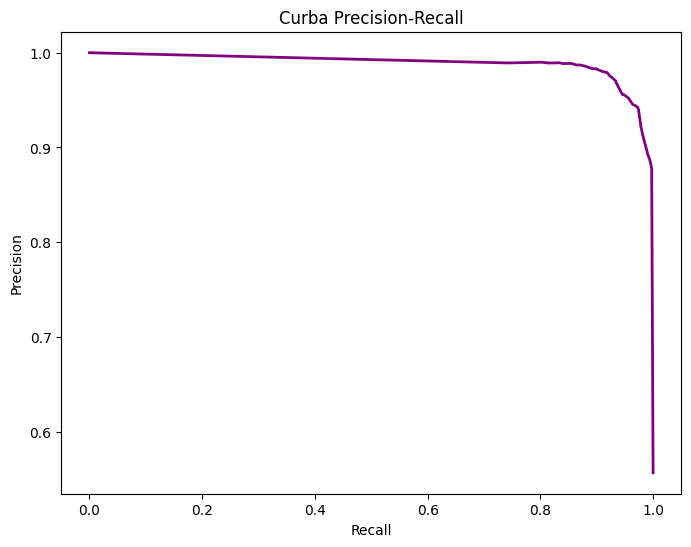

In [ ]:
plot_roc_curve(dt_tuned, X_test, y_test)
plot_confusion_matrix(dt_tuned, X_test, y_test)
plot_precision_recall_curve(dt_tuned, X_test, y_test)

### 7. Random Forest Classifier

De ce am ales acest model:

- Algoritm ensemble robust, reduce riscul de overfitting și oferă o bună performanță fără prea multă preprocesare.

Parametri tunati:

- n_estimators=200: un număr mai mare de estimatori reduce varianța, dar crește timpul de antrenare

- max_depth=15: controlul adâncimii ajută la echilibrarea bias-ului și varianței

- min_samples_split=10: reduce ramificările inutile și stabilizează modelul.

- min_samples_leaf=4: contribuie la generalizarea mai bună a modelului și la prevenirea ajustării excesive pe outlieri

- random_state=42: Asigură reproducibilitate între rulări

Performanța a fost similară cu varianta default, dar timpul de antrenare a crescut.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time

a. Parametri impliciti

In [ ]:
start = time.time()
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(X_train, y_train)
y_pred = rf_default.predict(X_test)

end = time.time()
training_time = end - start

print("=== Random Forest (default) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, rf_default.predict_proba(X_test)[:,1]))
print("CV F1-score:", cross_val_score(rf_default, X_train, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, rf_default.predict_proba(X_test)[:,1])
cv_f1 = cross_val_score(rf_default, X_train, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": " Random Forest (default)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })



=== Random Forest (default) ===
Training time: 0.8830 seconds
[[ 942   38]
 [  19 1212]]
              precision    recall  f1-score   support

          -1       0.98      0.96      0.97       980
           1       0.97      0.98      0.98      1231

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211

ROC AUC: 0.9976993153069514
CV F1-score: 0.973104444394108


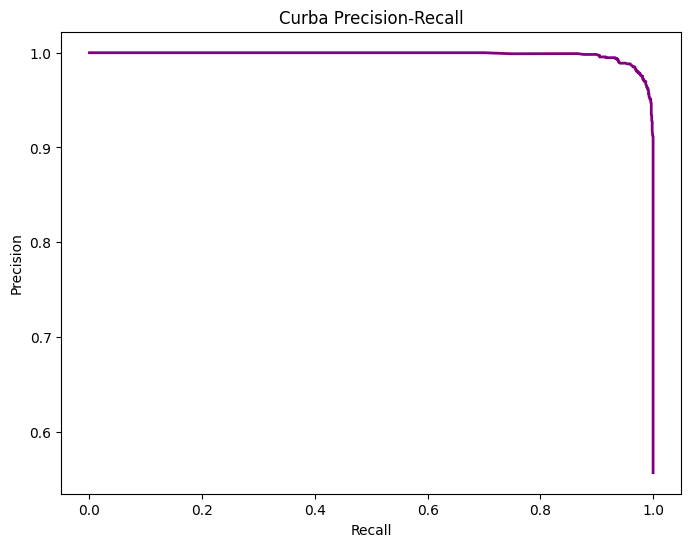

In [ ]:
plot_roc_curve(rf_default, X_test, y_test)
plot_confusion_matrix(rf_default, X_test, y_test)
plot_precision_recall_curve(rf_default, X_test, y_test)

b. Parametri alesi

In [ ]:
start = time.time()
rf_tuned = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)
rf_tuned.fit(X_train, y_train)
y_pred_tuned = rf_tuned.predict(X_test)

end = time.time()
training_time = end - start

print("=== Random Forest (tuned) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, rf_tuned.predict_proba(X_test)[:,1]))
print("CV F1-score:", cross_val_score(rf_tuned, X_train, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, rf_tuned.predict_proba(X_test)[:,1])
cv_f1 = cross_val_score(rf_tuned, X_train, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": " Random Forest (tuned)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== Random Forest (tuned) ===
Training time: 1.1854 seconds
[[ 919   61]
 [  29 1202]]
              precision    recall  f1-score   support

          -1       0.97      0.94      0.95       980
           1       0.95      0.98      0.96      1231

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211

ROC AUC: 0.9945266002420464
CV F1-score: 0.958712938302515


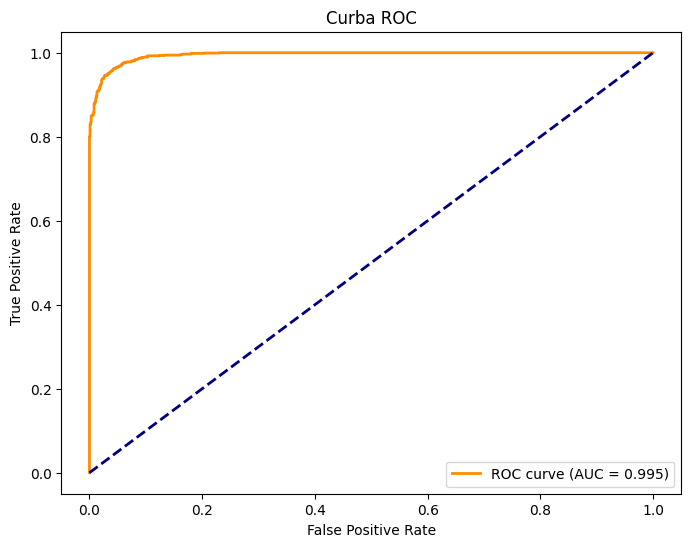

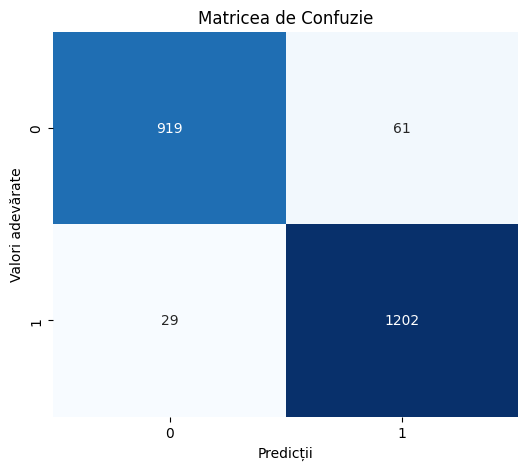

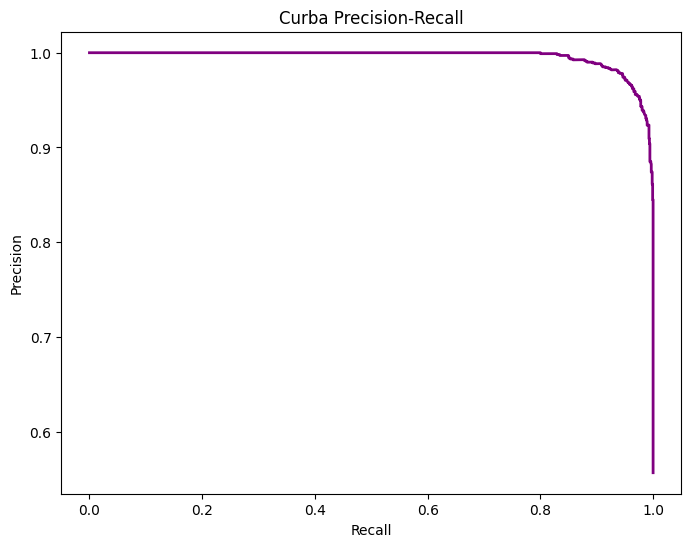

In [ ]:
plot_roc_curve(rf_tuned, X_test, y_test)
plot_confusion_matrix(rf_tuned, X_test, y_test)
plot_precision_recall_curve(rf_tuned, X_test, y_test)

### 8. Gradient Boosting Classifier

De ce am ales acest model:

- Algoritm performant, ideal pentru seturi de date structurale

Parametri tunati:

- n_estimators=200: învățare mai profundă, dar și timp de antrenare mai mare

- learning_rate=0.05: învață mai încet, dar mai precis

- max_depth=5:→ reduce complexitatea fiecărui model de bază

- min_samples_split=10: evită ramificările inutile pe date mici sau zgomotoase

- min_samples_leaf=3: reduce supra-specializarea

- random_state=42: asigura rezultate reproductibile

Tuningul a crescut scorul CV F1 și ROC AUC, dar a crescut și timpul de antrenare.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time

a. Parametri impliciti

In [ ]:
start = time.time()
gb_default = GradientBoostingClassifier(random_state=42)
gb_default.fit(X_train, y_train)
y_pred = gb_default.predict(X_test)

end = time.time()
training_time = end - start

print("=== Gradient Boosting (default) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, gb_default.predict_proba(X_test)[:,1]))
print("CV F1-score:", cross_val_score(gb_default, X_train, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc =  roc_auc_score(y_test, gb_default.predict_proba(X_test)[:,1])
cv_f1 = cross_val_score(gb_default, X_train, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": "  Gradient Boosting (default)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== Gradient Boosting (default) ===
Training time: 1.0349 seconds
[[ 922   58]
 [  46 1185]]
              precision    recall  f1-score   support

          -1       0.95      0.94      0.95       980
           1       0.95      0.96      0.96      1231

    accuracy                           0.95      2211
   macro avg       0.95      0.95      0.95      2211
weighted avg       0.95      0.95      0.95      2211

ROC AUC: 0.9920779522206934
CV F1-score: 0.9543554586911187


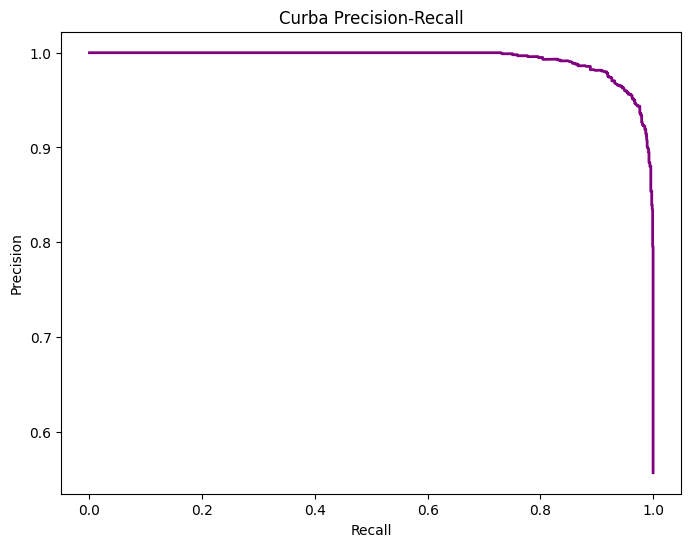

In [ ]:
plot_roc_curve(gb_default, X_test, y_test)
plot_confusion_matrix(gb_default, X_test, y_test)
plot_precision_recall_curve(gb_default, X_test, y_test)

b. Parametri alesi

In [ ]:
start = time.time()
gb_tuned = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=3,
    random_state=42
)
gb_tuned.fit(X_train, y_train)
y_pred_tuned = gb_tuned.predict(X_test)

end = time.time()
training_time = end - start

print("=== Gradient Boosting (tuned) ===")
print(f"Training time: {training_time:.4f} seconds")
print(confusion_matrix(y_test, y_pred_tuned))
print(classification_report(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, gb_tuned.predict_proba(X_test)[:,1]))
print("CV F1-score:", cross_val_score(gb_tuned, X_train, y_train, cv=5, scoring='f1').mean())

f1 = f1_score(y_test, y_pred)
roc_auc =  roc_auc_score(y_test, gb_tuned.predict_proba(X_test)[:,1])
cv_f1 = cross_val_score(gb_tuned, X_train, y_train, cv=5, scoring='f1').mean()

model_results.append({
        "Model": "  Gradient Boosting (tuned)",
        "F1 Score": round(f1, 4),
        "ROC AUC": round(roc_auc, 4),
        "CV F1 Score": round(cv_f1, 4),
        "Training Time (s)": round(training_time, 3)
    })


=== Gradient Boosting (tuned) ===
Training time: 3.2206 seconds
[[ 937   43]
 [  32 1199]]
              precision    recall  f1-score   support

          -1       0.97      0.96      0.96       980
           1       0.97      0.97      0.97      1231

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211

ROC AUC: 0.9956299010262106
CV F1-score: 0.9650341824646935


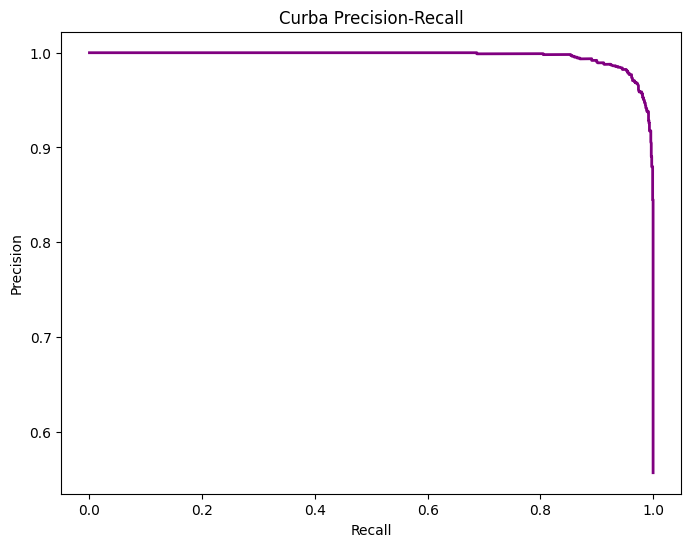

In [ ]:
plot_roc_curve(gb_tuned, X_test, y_test)
plot_confusion_matrix(gb_tuned, X_test, y_test)
plot_precision_recall_curve(gb_tuned, X_test, y_test)

## Comparare rezultate

 Pentru evaluarea modelelor de clasificare, s-au utilizat mai multe metrici relevante: F1-score, ROC AUC, Scorul F1 pe validare încrucișată (CV F1) și Timpul de antrenare.

 - Cea mai bună performanță generală a fost obținută de Random Forest (default), care a avut cel mai mare F1-score (0.9770) și cel mai mare AUC (0.9977), cu un timp de antrenare rezonabil.

- MLPClassifier (default) a avut o performanță comparabilă, dar cu un timp de antrenare semnificativ mai mare (16 secunde).

- Gradient Boosting (tuned) a oferit un compromis bun între performanță și complexitate, având un AUC de 0.9956 și un F1-score solid (0.9580).

- KNN (tuned) a fost extrem de rapid (0.003 sec), menținând o performanță rezonabilă (F1: 0.9539).

- GaussianNB, deși rapid, a avut performanță slabă (F1: 0.4415), ceea ce indică faptul că ipoteza de distribuție normală nu este adecvată pentru acest set de date.

Tuningul nu a dus întotdeauna la o creștere a F1-score-ului (ex. Random Forest și MLP), dar în unele cazuri a redus timpul de antrenare sau a crescut scorul AUC/CV F1.

In [ ]:
results_df = pd.DataFrame(model_results)

results_df["Model"] = results_df["Model"].str.strip()

results_df = results_df.sort_values(by="F1 Score", ascending=False)

results_df.reset_index(drop=True, inplace=True)

pd.set_option('display.precision', 4)
pd.set_option('display.colheader_justify', 'center')
print(results_df.to_string(index=False))

            Model              F1 Score  ROC AUC  CV F1 Score  Training Time (s)
      Random Forest (default)   0.9770   0.9977     0.9731           0.883      
        Random Forest (tuned)   0.9770   0.9945     0.9587           1.185      
      MLPClassifier (default)   0.9763   0.9970     0.9702          18.554      
        MLPClassifier (tuned)   0.9763   0.9961     0.9673           7.952      
      Decision Tree (default)   0.9741   0.9805     0.9645           0.026      
        Decision Tree (tuned)   0.9741   0.9865     0.9491           0.036      
    Gradient Boosting (tuned)   0.9580   0.9956     0.9650           3.221      
  Gradient Boosting (default)   0.9580   0.9921     0.9544           1.035      
                  SVC (tuned)   0.9573   0.9915     0.9541           7.808      
                SVC (default)   0.9573   0.9893     0.9537           8.315      
                  KNN (tuned)   0.9539   0.9922     0.9664           0.006      
                KNN (default

<ipython-input-24-497598138>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=training_times, palette="viridis")


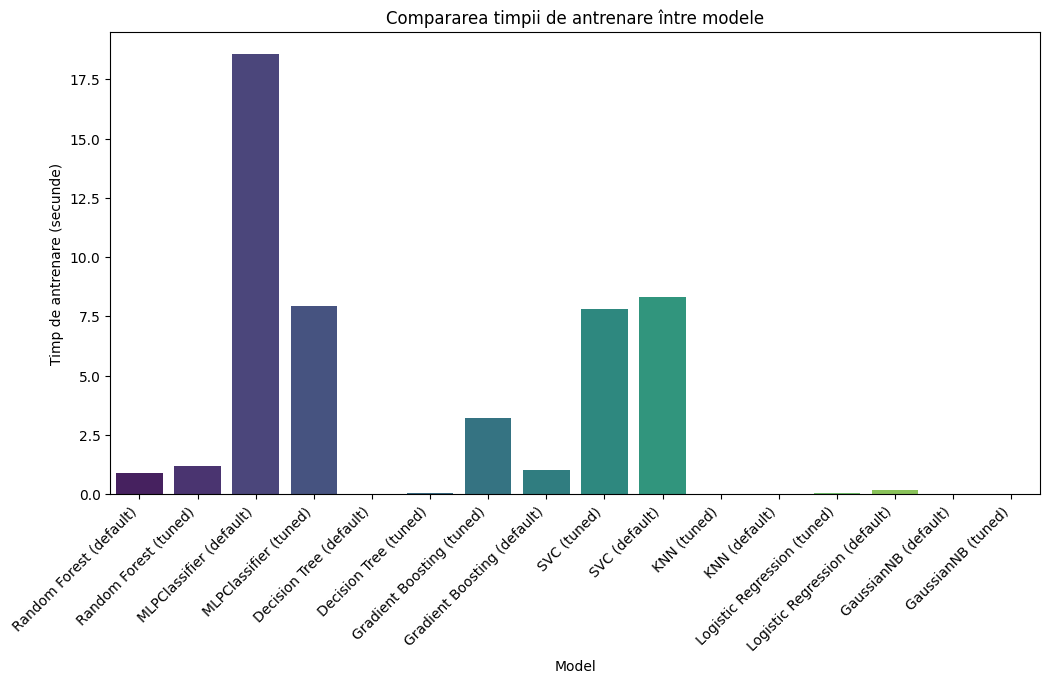

In [ ]:
plot_training_times(results_df["Model"], results_df["Training Time (s)"])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asigură-te că ai DataFrame-ul numit results_df
results_df_sorted = results_df.sort_values(by="CV F1 Score", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x="CV F1 Score",
    y="Model",
    data=results_df_sorted,
    palette="viridis"
)

plt.title("Top modele după CV F1 Score")
plt.xlabel("CV F1 Score")
plt.ylabel("Model")
plt.xlim(0.4, 1)  # Opțional, pentru claritate
plt.tight_layout()
plt.show()


<ipython-input-67-2555401166>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


<ipython-input-68-3577306820>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


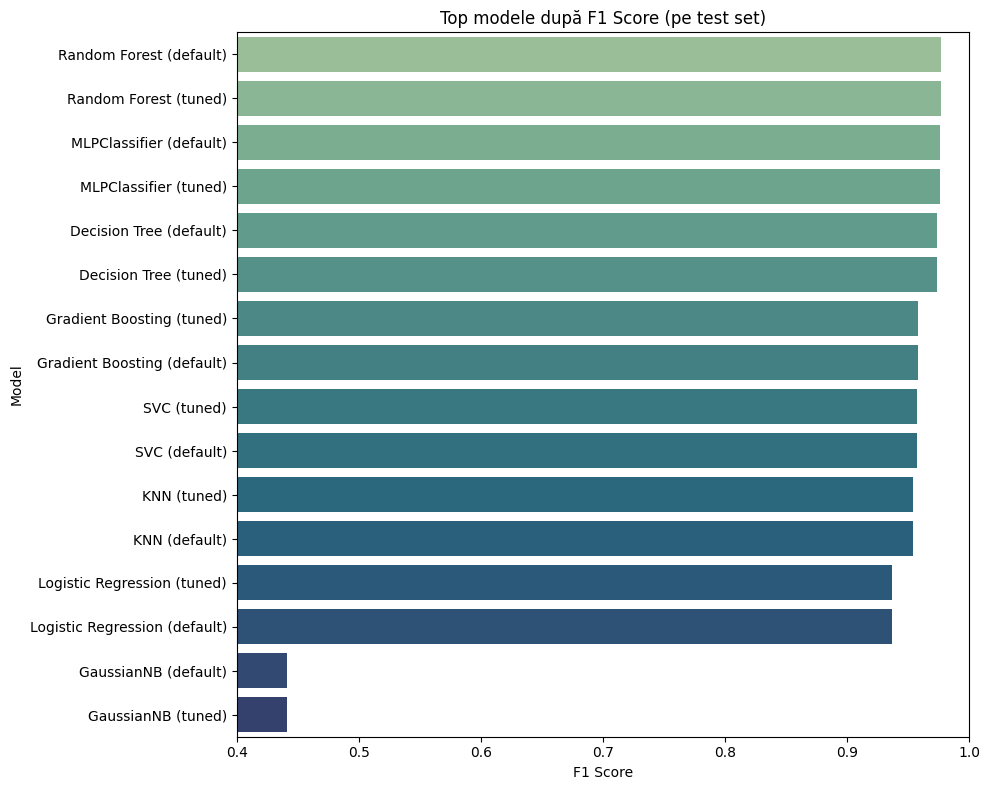

In [ ]:
results_df_sorted = results_df.sort_values(by="F1 Score", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x="F1 Score",
    y="Model",
    data=results_df_sorted,
    palette="crest"
)

plt.title("Top modele după F1 Score (pe test set)")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.xlim(0.4, 1)
plt.tight_layout()
plt.show()
